In [1]:
# !pip install spacy

In [2]:
# !python -m spacy download en_core_web_sm

In [3]:
# !pip install torch

# Sentiment analysis with Spacy SM model

The idea of this notebook is to test the framework spacy in order to do text classification. In order to do so we will work in the classical case of sentiment analysis. The data used come from the follwoing [kaggle competion](https://www.kaggle.com/c/tweet-sentiment-extraction). It contains about 25K tweets annotated with sentiments. It also contains subtext which actually contains the sentiment, but we won't use it in this task. The data will be stored in a `data` folder beside the git repository folder.

## Imports

In [25]:
import os

import torch
import random
import pandas as pd

import spacy
from spacy.util import minibatch, compounding
from spacy.training import Example
from spacy.tokens import DocBin
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

from sklearn.metrics import accuracy_score,\
    f1_score, recall_score, precision_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as  tqdm

## Loading data

In [5]:
tweet_sentiment_df = pd.read_csv('../data/tweet_sentiment.csv')
print(tweet_sentiment_df.shape)
tweet_sentiment_df.head()

(27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### Count the number of texts within each class

In [6]:
tweet_sentiment_df.sentiment.value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

#### *Observation*:
The dataset seems fairly balanced between the 3 difference classes. However we will still resample it for the training only in order to have perfectly balnced classes.

## Data preprocessing 

In [7]:
# Drop null values
tweet_sentiment_df = tweet_sentiment_df.dropna()

### Format data in order to be compatible with spacy framework

In [8]:
def format_text_and_sentiment(row, text_col: str = 'text'):
    return (row[text_col], {"cats": {k: 1.0 if (row['sentiment'] == k) else 0.0 for k in ['negative', 'neutral', 'positive']}})

In [9]:
tweets = [format_text_and_sentiment(dict(zip(tweet_sentiment_df.columns, row))) for row in tqdm(tweet_sentiment_df.values)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/27480 [00:00<?, ?it/s]

#### Shuffle data

In [10]:
shuffle_tweets = tweets.copy()
random.seed(42)
print("Original first tweet : ", shuffle_tweets[0])
random.shuffle(shuffle_tweets)
print("After shuffling first tweet : ", shuffle_tweets[0])

Original first tweet :  (' I`d have responded, if I were going', {'cats': {'negative': 0.0, 'neutral': 1.0, 'positive': 0.0}})
After shuffling first tweet :  ('Bottle of reisling this time... My favorite!', {'cats': {'negative': 0.0, 'neutral': 0.0, 'positive': 1.0}})


### Split the data between train, val and test

We will also resample the training dataset in order to make it perfectly balanced

In [11]:
pre_train, val, test = tweets[:24000], tweets[24000:25000], tweets[25000:27000]

pre_train_positive = [example for example in pre_train if example[1]['cats']['positive'] == 1.]
print("Initial nb positive : ", len(pre_train_positive))
train_positive = random.sample(pre_train_positive,k=4000)
print("Nb positive in train : ", len(train_positive))

pre_train_neutral = [example for example in pre_train if example[1]['cats']['neutral'] == 1.]
print("Initial nb neutral : ", len(pre_train_neutral))
train_neutral = random.sample(pre_train_neutral,k=4000)
print("Nb neutral in train : ", len(train_neutral))

pre_train_negative = [example for example in pre_train if example[1]['cats']['negative'] == 1.]
print("Initial nb negative : ", len(pre_train_negative))
train_negative = random.sample(pre_train_negative,k=4000)
print("Nb negative in train : ", len(train_negative))

train = train_positive + train_neutral + train_negative
print('Lenght train : ', len(train))
print('Lenght val : ', len(val))
print('Lenght test : ', len(test))

Initial nb positive :  7561
Nb positive in train :  4000
Initial nb neutral :  9657
Nb neutral in train :  4000
Initial nb negative :  6782
Nb negative in train :  4000
Lenght train :  12000
Lenght val :  1000
Lenght test :  2000


## Modeling

#### Use GPU if it is available

In [12]:
is_using_gpu = spacy.prefer_gpu()
if is_using_gpu:
    print("Is using GPU")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

#### Load the prebuilt model from spacy

In [13]:
nlp = en_core_web_sm.load()

#### Add Text categorizer in the pipeline of the model

In [14]:
print("Original pipeline : ", nlp.pipe_names)

textcat = nlp.add_pipe("textcat")
for label in ("positive", "neutral", "negative"):
    textcat.add_label(label)

print("New pipeline : ", nlp.pipe_names)

Original pipeline :  ['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']
New pipeline :  ['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'textcat']


#### Function to evaluate the model on the validation or the test dataset
(I know I could have paralellize this piece of code for efficienty, but as the code was still runing in reasonable time, and as it wasn't the purpose of this notebook, I decided not to for easier readability.)

In [15]:
def evaluate_model(
    nlp, test_data: list
) -> dict:
    reviews, labels = [x[0] for x in test_data], [x[1] for x in test_data]
    predicted_labels = []
    true_labels = []
    for i, review in tqdm(enumerate(reviews)):
        positive_score = nlp(review).cats["positive"]
        neutral_score = nlp(review).cats["neutral"]
        negative_score = nlp(review).cats["negative"]
        if (positive_score > neutral_score) and (positive_score > negative_score):
            predicted_labels.append("positive")
        elif (negative_score > neutral_score) and (negative_score > positive_score):
            predicted_labels.append("negative")
        else:
            predicted_labels.append("neutral")

        if labels[i]["cats"]["positive"] > 0.5:
            true_labels.append("positive")
        elif labels[i]["cats"]["negative"] > 0.5:
            true_labels.append("negative")
        else:
            true_labels.append("neutral")

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return {"precision": round(precision, 5),
            "recall": round(recall, 5),
            "f1-score": round(f1, 5)}

### Model training

In [16]:
nb_epochs = 5

# Disable the part of the pipelines which aren't necessary
with nlp.disable_pipes(['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']):
    # Create the optimizer
    optimizer = nlp.create_optimizer()
    # Build the exmple in with the right type for spacy model training
    examples = []
    for text, annots in train:
        examples.append(Example.from_dict(nlp.make_doc(text), annots))
    # Iniitalize the text categorizer
    nlp.get_pipe("textcat").initialize(lambda: examples, nlp=nlp)
    # We will use the f1 score to juge the best model and save it during the training
    best_f1_score = 0
    list_of_epoch_performances = []
    # Loop over the epochs 
    for i in range(1, nb_epochs+1):
        # Shuffle the example at the begining of each epoch
        random.shuffle(examples)
        losses = {}
        # loop over the batchs
        for batch in tqdm(minibatch(examples, size=64)):
            nlp.update(batch, sgd=optimizer, losses=losses, drop=0.2)
        # Print the loss on the training data
        print(f"Loss after {i}/{nb_epochs} : ", losses)
        # Evaluate model performances on the validation set
        model_performances = evaluate_model(nlp, val)
        # Log the current performances
        model_performances['epoch'] = i
        list_of_epoch_performances.append(model_performances)
        print(model_performances)
        # If the model was beter that ever on the validation set we update its saved version
        if model_performances["f1-score"] > best_f1_score:
            nlp.to_disk("../models/sm-textcat")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

Loss after 1/5 :  {'tok2vec': 0.0, 'textcat': 0.026421746821142733}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

{'precision': 0.66685, 'recall': 0.642, 'f1-score': 0.64393, 'epoch': 1}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

Loss after 2/5 :  {'tok2vec': 0.0, 'textcat': 0.020355791464680806}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

{'precision': 0.67811, 'recall': 0.675, 'f1-score': 0.67336, 'epoch': 2}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

Loss after 3/5 :  {'tok2vec': 0.0, 'textcat': 0.017308456350292545}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

{'precision': 0.66842, 'recall': 0.658, 'f1-score': 0.65254, 'epoch': 3}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

Loss after 4/5 :  {'tok2vec': 0.0, 'textcat': 0.014646464464021847}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

{'precision': 0.66792, 'recall': 0.653, 'f1-score': 0.6459, 'epoch': 4}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

Loss after 5/5 :  {'tok2vec': 0.0, 'textcat': 0.012276005563762737}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

{'precision': 0.67423, 'recall': 0.669, 'f1-score': 0.66413, 'epoch': 5}


### Save the logged performances of the model over the epochs

In [17]:
epoch_performances_df = pd.DataFrame(list_of_epoch_performances)
epoch_performances_df.to_csv('../data/spacy_sm_epoch_performances_df.csv')

In [18]:
epoch_performances_df

,precision,recall,f1-score,epoch
0,0.66685,0.642,0.64393,1
1,0.67811,0.675,0.67336,2
2,0.66842,0.658,0.65254,3
3,0.66792,0.653,0.64590,4
4,0.67423,0.669,0.66413,5


## Model final testing
We will now evaluate the model on the test set.

### Load the saved best model

In [19]:
nlp = spacy.load("../models/sm-textcat")

### Get the ground truth labels for the test set

In [20]:
true_label_test = [[k for k, v in t[1]['cats'].items() if v > 0.5][0] for t in test]
true_label_test[:5]

['negative', 'neutral', 'neutral', 'negative', 'neutral']

### Get the predicted labels for the test set

In [21]:
test_results = nlp.pipe([x[0] for x in test])

In [22]:
preds = []
for i, test_res in enumerate(test_results):
    scores = list(test_res.cats.values())
    keys = list(test_res.cats.keys())
    preds.append(keys[scores.index(max(scores))])

In [23]:
preds[:5]

['negative', 'positive', 'neutral', 'negative', 'neutral']

### Build the confusion matrix of the model on the test dataset

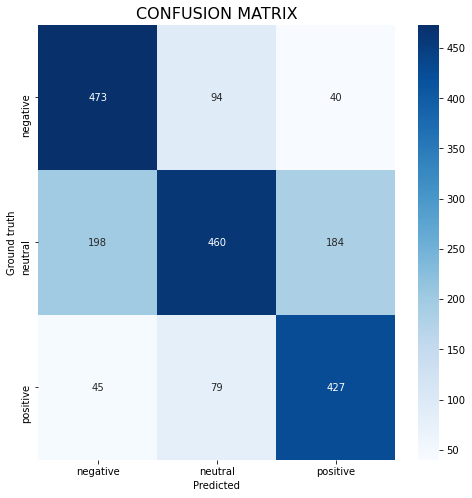

In [27]:
conf_mat = confusion_matrix(true_label_test, preds)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('Ground truth')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX", size=16);

### Evaluate the model performances on the test dataset
We will compute the precision, recall and f1-score of the model over the dataset.

In [28]:
model_performances = evaluate_model(nlp, test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [29]:
model_performances

{'precision': 0.68714, 'recall': 0.68, 'f1-score': 0.67534}

#### *Observation*:
The model is doing a decente job on sentiment categorization with an F1 socre of 67.5% on the test set. When looking at the confusion matrix we can see that the positive class mix a bit with the neutral classe, and the negative class with the neutral one as well. But the negative class is not really mixed up with the positive one, which is really good.